## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

## Import libraries for the model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Set path for saving model training results 
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'sp500'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get-tag-names.tql?table={table}'

## Generate tag name list
tag_name = show_column(NAME_URL)

In [4]:
len(tag_name)

2510

## Converting TAG Name Format
* After checking all the Tag Names from the S&P500 dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Using Apple Inc. data -> AAPL

In [5]:
# Set the desired tag names
tags = ['AAPL_volume']
# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)

# Check the selected tag names
print(tags_)

'AAPL_volume'


## Load S&P500 Dataset
* Load the data using the Tag Names.

In [6]:
# Data loading parameter settings

# Set the tag table name
table = 'sp500'
# Set the tag names
name = quote(tags_, safe=":/")
# Set the time format
timeformat = 'default'
# Set the data start time
start_time = quote('2017-09-11 09:30:00')
# Set the data end time
end_time = quote('2018-02-16 16:00:00')

In [7]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load the data
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')
    
    # Transform to data by the same time zone
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()
    
    # Convert 'TIME' column to datetime format
    df['TIME'] = pd.to_datetime(df['TIME'])
    df = df.set_index(pd.to_datetime(df['TIME']))
    df = df.drop(['TIME'], axis=1)
    
    # Time series decomposition
    decomposition = seasonal_decompose(df['AAPL_volume'], model='additive', period=24)

    # Use only the trend
    trend = decomposition.trend 
    
    # Create a new DataFrame
    df = pd.DataFrame(trend.dropna().values, columns=['value'])
    df.index = trend.dropna().index
    
    # Create new columns with window applied
    df['lag1'] = df['value'].shift(1)  # Previous 1-min data
    df['lag2'] = df['value'].shift(2)  # Previous 2-min data
    df['lag3'] = df['value'].shift(3)  # Previous 3-min data
    df['lag4'] = df['value'].shift(4)  # Previous 4-min data 
    
    # Remove missing values
    df = df.dropna()
    
    # Move 'value' column to the end
    df['value'] = df.pop('value')

    return df

In [8]:
# Load the data
df = data_load(table, name, start_time, end_time, timeformat)

# Split the data into training and testing sets

# Set training data to include data before February 2018
train = df[df.index < '2018-02-01']

# Set testing data to include data after February 2018
test = df[df.index > '2018-02-01']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

df

,lag1,lag2,lag3,lag4,value
TIME,,,,,
2017-09-11 09:46:00,159135.645833,162425.312500,166430.729167,175771.895833,155084.291667
2017-09-11 09:47:00,155084.291667,159135.645833,162425.312500,166430.729167,152413.625000
2017-09-11 09:48:00,152413.625000,155084.291667,159135.645833,162425.312500,149847.270833
2017-09-11 09:49:00,149847.270833,152413.625000,155084.291667,159135.645833,148117.395833
2017-09-11 09:50:00,148117.395833,149847.270833,152413.625000,155084.291667,146488.166667
...,...,...,...,...,...
2018-02-16 15:43:00,83978.583333,83376.416667,83171.500000,82149.291667,85588.541667
2018-02-16 15:44:00,85588.541667,83978.583333,83376.416667,83171.500000,86543.916667
2018-02-16 15:45:00,86543.916667,85588.541667,83978.583333,83376.416667,88639.250000


## Data Preprocessing
* 1 Decomposition -> Applied in advance
* 2 Min-Max Scaling

### 2. Min-Max Scaling

In [9]:
# Set a separate scaler for volume for the subsequent reconstruction process

# Data scaler setup
scaler_data = MinMaxScaler()

# Apply data scaler
train_data = scaler_data.fit_transform(train.iloc[:, :-1].values)
test_data = scaler_data.transform(test.iloc[:, :-1].values)

# Target scaler setup
scaler_target = MinMaxScaler()

# Apply target scaler
train_target = scaler_target.fit_transform(train.iloc[:, -1:].values)
test_target = scaler_target.transform(test.iloc[:, -1:].values)

# DataFrame setup
train_scaled = pd.DataFrame(train_data)
train_scaled['volume'] = train_target

test_scaled = pd.DataFrame(test_data)
test_scaled['volume'] = test_target

## Dataset & Loader Setup

In [10]:
# Dataset class setup
class Dataset():

    def __init__(self, df):
        self.data = df.iloc[:, :-1]
        self.target = df.iloc[:, -1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Process feature data
        input_time_data = self.data.iloc[index, :]
        input_time_data = torch.Tensor(input_time_data).expand(1, input_time_data.shape[0])

        # Process target value
        target = torch.Tensor([self.target.iloc[index]])

        return input_time_data, target

In [11]:
# Dataset setup
train_ = Dataset(train_scaled)
test_ = Dataset(test_scaled)

# DataLoader setup
train_dataloader = DataLoader(train_, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_, batch_size=1, shuffle=False)

In [12]:
# Verify DataLoader application and check the shape of the input data
print(list(train_dataloader)[0][0].shape)

torch.Size([64, 1, 4])


## Model Configuration
* Using BILSTM model.

In [13]:
# BILSTM Model Configuration
class BILSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,dropout=0.2, bidirectional=False):
        super(BILSTM, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=bidirectional)
        
        self.lstm2 = nn.LSTM(2*hidden_size, 2*hidden_size, num_layers, 
                    batch_first=True,dropout=dropout, bidirectional=bidirectional)
        
        self.fc = nn.Linear(2* hidden_size * (2 if bidirectional else 1), 1)
        
        self.layer_norm = nn.LayerNorm(3)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm1(x)
        out, (h_n, c_n) = self.lstm2(out)
        out = self.fc(out[:, -1, :])
        return out

In [14]:
# Model configuration parameters

# Number of input data columns
# Last number in print(list(train_dataloader)[0][0].shape)
input_dim = 4

# Size of the hidden state
hidden_dim = 64

# Number of layers
num_layers = 2

# Learning rate
learning_rate = 0.01

# Model configuration
model = BILSTM(input_dim, hidden_dim, num_layers, bidirectional=True).to(device)

# Configure loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

BILSTM(
  (lstm1): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (lstm2): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (layer_norm): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
)


## Model Training
* Save the model with the best loss based on the validation data during training.

In [15]:
# Initialize training loss
train_loss = []
# Initialize total step
total_step = len(train_dataloader)
# Set number of epochs
epoch_in = trange(100, desc='training')
# Initialize best loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:

    model.train()
    
    # Initialize loss
    running_loss = 0.0

    for batch_idx, train_data in enumerate(train_dataloader):

        inputs = train_data[0].to(device).float()
        target = train_data[1].to(device).float()

        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs.squeeze(), target[:, -1])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Print training loss
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss)}')

    # Save the model if it has the best loss
    if best_Loss > np.mean(train_loss):
        best_Loss = np.mean(train_loss)
        torch.save(model, f'./result/sp500_BILSTM_General.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 0.00044432248174051893
Model saved

train loss: 0.0003144722316767967
Model saved

train loss: 0.00023459624788206543
Model saved

train loss: 0.00018992096465562662
Model saved

train loss: 0.00017357180743438495
Model saved

train loss: 0.00015608842217448447
Model saved

train loss: 0.00014309741411545985
Model saved

train loss: 0.00013158572478599954
Model saved

train loss: 0.0001253842903736975
Model saved

train loss: 0.00011793966211243425
Model saved

train loss: 0.0001131148425258133
Model saved

train loss: 0.00012479802085523675

train loss: 0.00011976928243720963

train loss: 0.00011485098167790762

train loss: 0.00011067963447423949
Model saved

train loss: 0.00010641848978592541
Model saved

train loss: 0.0001034369755198883
Model saved

train loss: 9.979936847043862e-05
Model saved

train loss: 9.863470896545673e-05
Model saved

train loss: 9.59707998035833e-05
Model saved

train loss: 9.31184719711668e-05
Model saved

train loss: 9.040803218260582e-05
Mod

## Model Testing

In [16]:
# Load the best model
model_ = torch.load(f'./result/sp500_BILSTM_General.pt')

In [17]:
# Initial settings 
output_test = []
target_test = []

# Model Testing
with torch.no_grad():
    model_.eval()
    running_loss_t = 0.0
    
    for batch_idx, test_data in enumerate(test_dataloader):
        
        inputs_t = test_data[0].to(device).float()
        target_t = test_data[1].to(device).float()

        outputs_t = model_(inputs_t)
        
        output_test.append(outputs_t)
        target_test.append(target_t)
        
# Combine the tensors into one
combined_tensor_target = torch.cat(target_test, dim=0)
combined_tensor_pred = torch.cat(output_test, dim=0)

# Use only the last values of the window
last_values_target = combined_tensor_target[:, -1].cpu()
last_values_pred = combined_tensor_pred.cpu()

# Inverse transform using MinMaxScaler 
real_values = scaler_target.inverse_transform(last_values_target.numpy().reshape(-1, 1))
real_pred_values = scaler_target.inverse_transform(last_values_pred.numpy().reshape(-1, 1))

## Model Performance Evaluation

In [18]:
# Calculate MSE
mse = mean_squared_error(real_values, real_pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, real_pred_values)
print("R² Score:", r2)

Mean Squared Error: 53460372.0
R² Score: 0.993311082211334


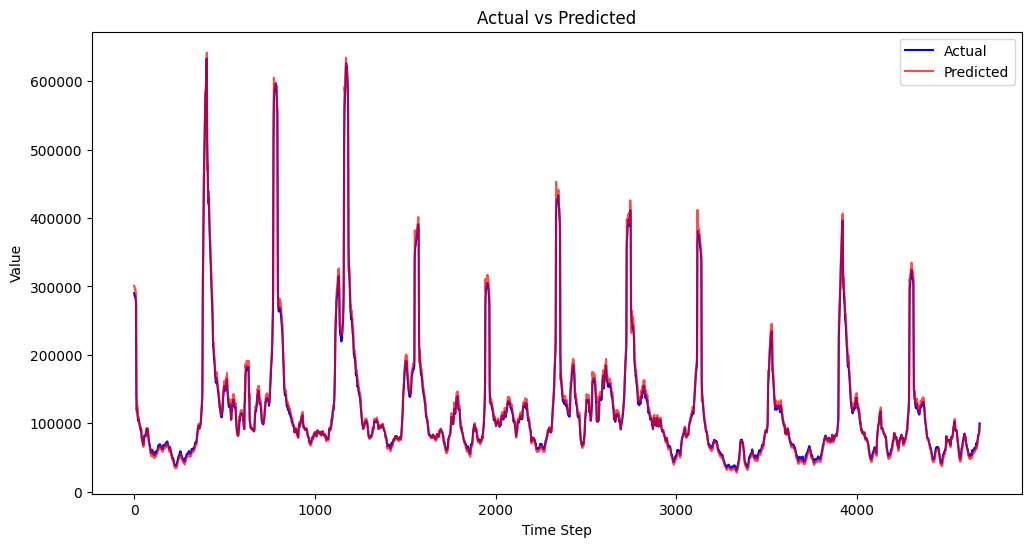

In [19]:
# Compare the test results: Actual values vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='Actual', color='blue')
plt.plot(real_pred_values, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()